In [1]:
import time, math, random
from game import CoinGaime

Cheaters are only biased against heads!

In [10]:
import io
import time
import base64 
import numpy as np
from PIL import Image
import pytesseract as tess

tess.pytesseract.tesseract_cmd = "C:\\Users\\alber\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe"

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains


class CoinGame():

    def __init__(self, animation_wait_time=1):

        self.window_size = (300,850)

        self.driver = self._get_driver()
        self.driver.set_window_size(*self.window_size)
        self.driver.get('https://primerlearning.org/')
        self.element = self.driver.find_element_by_id("coin-flip-app")
        self.show_flipping = True
        self.reset_window()
        self.animation_wait_time = animation_wait_time
        time.sleep(30)
        self.show_flipping_animations()

    def wait_for_animations(self):
        time.sleep(self.animation_wait_time)

    def _get_driver(self):
        chrome_options = webdriver.ChromeOptions()
        mobile_emulation = { "deviceName": "iPhone 6" }
        chrome_options.add_experimental_option("mobileEmulation", mobile_emulation)
        return webdriver.Chrome(options= chrome_options)

    def reset_window(self):
        self.driver.set_window_size(*self.window_size)
        self.driver.execute_script("arguments[0].scrollIntoView();", self.element)

    def get_page_screenshot(self):
        screenshot = self.driver.get_screenshot_as_base64()
        screenshot = base64.b64decode(screenshot)
        screenshot = io.BytesIO(screenshot)
        screenshot = Image.open(screenshot).convert('L')
        return screenshot

    @staticmethod
    def _get_image_text(image):
        return tess.image_to_string(image)

    def get_flips(self) -> dict:
        if self.flips is None:
            self.get_data()
        return self.flips
    
    
        
        screenshot = self.get_page_screenshot()
        cropped = screenshot[490:600, 325:550]
        text = CoinGaime._get_image_text(cropped)
        if 'Heads: ' in text and 'Tails: ' in text:
            text_tuples = [line.split(': ') for line in text.split('\n')[:2]]
            text_dict = {k: int(v) for k, v in text_tuples}
            return text_dict
        return {'Heads': 0, 'Tails': 0}

    def get_end_score(self):
        screenshot = self.get_page_screenshot()
        cropped = screenshot[450:650]
        text = CoinGaime._get_image_text(cropped)
        if 'Score: ' in text:
            return int(text.split('Score: ')[1])
        return None

    def _click_location(self, x, y):
        action = ActionChains(self.driver)
        action.move_to_element_with_offset(self.element, x, y)
        action.click()
        action.perform()
        self.wait_for_animations()
    
    # Clicking locations:
    # Game: x, y = 20, 20
    # Leaderboard x, y = 330, 20
    # 1 Coin: x, y = 20, 500
    # 5 Coins: x, y = 330, 500
    # Show flipping animation: x, y = 50, 550
    # Fair: x, y = 20, 600
    # Cheater x, y = 330, 600
    # Reset Game: x, y = 155, 600

    def click_game_tab(self):
        self._click_location(20, 20)

    def click_leaderboard_tab(self):
        self._click_location(330, 20)

    def flip_one_coin(self):
        self._click_location(20, 500)
    
    def flip_five_coins(self):
        self._click_location(330, 500)
    
    def show_flipping_animations(self):
        self.show_flipping = not self.show_flipping
        self._click_location(50, 550)
    
    def label_fair(self):
        self._click_location(20, 600)

    def label_cheater(self):
        self._click_location(330, 600)

    def reset_game(self):
        self._click_location(155, 600)
        self.reset_window()
    
    def restart_browser(self):
        self.driver.quit()
        self.__init__()

g = CoinGame()

In [ ]:
iters = 0
confidence = 0.1
while g.get_score() is None:
    iters += 1
    if random.random() > 0.5:
        g.label_fair()
    else:
        g.label_cheater()
    time.sleep(2)
print(g.get_score())

In [25]:
%%timeit
screenshot = g.driver.get_screenshot_as_base64()
screenshot = base64.b64decode(screenshot)
screenshot = io.BytesIO(screenshot)
screenshot = Image.open(screenshot).convert('L')
#screenshot = np.asarray(screenshot)
#cropped = screenshot[490:600, 325:550] #271 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cropped = screenshot.crop((490, 550, 325, 600)) # 245 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

237 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


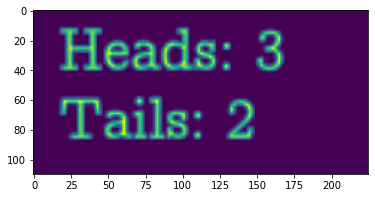

In [29]:
import matplotlib.pyplot as plt
#screenshot = g.get_page_screenshot()
#crop = screenshot[450:650]
cropped = screenshot.crop((325, 490, 550, 600))
plt.imshow(cropped)